In [1]:
import torch, torchvision.transforms as T
from torchvision import models
from PIL import Image
import os, glob, pandas as pd, numpy as np, scipy.stats as stats, matplotlib.pyplot as plt, seaborn as sns
from torchvision.models import alexnet, AlexNet_Weights
from sklearn.decomposition import PCA

## alexnet stuff

In [2]:
# load pretrainded AlexNet model
model = models.alexnet(weights=AlexNet_Weights.DEFAULT).eval()
# remove the last layer to get the feature vector
model.classifier = torch.nn.Sequential(*list(model.classifier.children())[:-1])
# transform the input image to the format expected by the model
transform = T.Compose([T.Resize(256), T.CenterCrop(224), T.ToTensor(), T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

def get_embeddings(img_path):
    img = transform(Image.open(img_path).convert('RGB')).unsqueeze(0)
    with torch.no_grad():
    # with torch.no_grad() is used to disable gradient calculation
        return model(img)

## get embeddings of stims used in expt

In [3]:
# # get list of shapes used as targets
# trials_df = pd.read_csv('../input_data/trials.csv')
# shape_files_used = trials_df['target_file'].tolist()
# embeddings = [(shape_file, get_embeddings(os.path.join('../', shape_file))) for shape_file in shape_files_used]

# # convert to df
# embeddings_df = pd.DataFrame([(k, *v.squeeze().numpy()) for k, v in embeddings])
# embeddings_df.columns = ['shapes'] + [f'feature_{i}' for i in range(embeddings_df.shape[1] - 1)]

# # append associated stim & noise positions
# embeddings_df['stim_file_pos'] = trials_df['stim_file_pos']
# embeddings_df['noise_pos'] = trials_df['noise_pos']
# reorder_columns = ['shapes', 'stim_file_pos', 'noise_pos'] + [col for col in embeddings_df.columns if col.startswith('feature_')]
# embeddings_df = embeddings_df[reorder_columns]

# # remove features with minimal variance across shapes
# feature_cols = [col for col in embeddings_df.columns if col.startswith('feature_')]
# variances = embeddings_df[feature_cols].var()
# threshold = 0.2
# low_variance_features = variances[variances < threshold].index
# embeddings_df = embeddings_df.drop(columns=low_variance_features)

# embeddings_df.to_csv('../input_data/stimuli_embeddings.csv', index=False)

embeddings_df = pd.read_csv('../input_data/stimuli_embeddings.csv')
print(len(embeddings_df))
embeddings_df.head()


240


,shapes,stim_file_pos,noise_pos,feature_38,feature_45,feature_47,feature_52,feature_60,feature_88,feature_89,...,feature_3978,feature_3989,feature_4029,feature_4058,feature_4062,feature_4068,feature_4072,feature_4073,feature_4076,feature_4091
0,input_data/stims/Shape_0.10_1.00.png,0.1,1.0,0.0,4.321363,0.265191,10.104380,6.563837,0.897169,5.857170,...,1.309970,0.689861,16.736954,5.845687,1.352016,0.0,2.771213,5.519984,0.293255,0.0
1,input_data/stims/Shape_0.10_1.00.png,0.1,1.0,0.0,4.321363,0.265191,10.104380,6.563837,0.897169,5.857170,...,1.309970,0.689861,16.736954,5.845687,1.352016,0.0,2.771213,5.519984,0.293255,0.0
2,input_data/stims/Shape_0.30_1.00.png,0.3,1.0,0.0,5.103432,0.098392,10.506258,6.886869,0.451986,6.409008,...,0.974600,0.674793,16.914658,6.205310,1.119534,0.0,2.433510,5.862866,0.000000,0.0
3,input_data/stims/Shape_0.30_1.00.png,0.3,1.0,0.0,5.103432,0.098392,10.506258,6.886869,0.451986,6.409008,...,0.974600,0.674793,16.914658,6.205310,1.119534,0.0,2.433510,5.862866,0.000000,0.0
4,input_data/stims/Shape_0.50_1.00.png,0.5,1.0,0.0,5.420555,0.012235,10.232821,7.231481,1.283351,5.765145,...,1.027748,0.609162,16.070360,6.721252,0.987496,0.0,1.914770,5.642951,0.686270,0.0


## plot stim embeddings

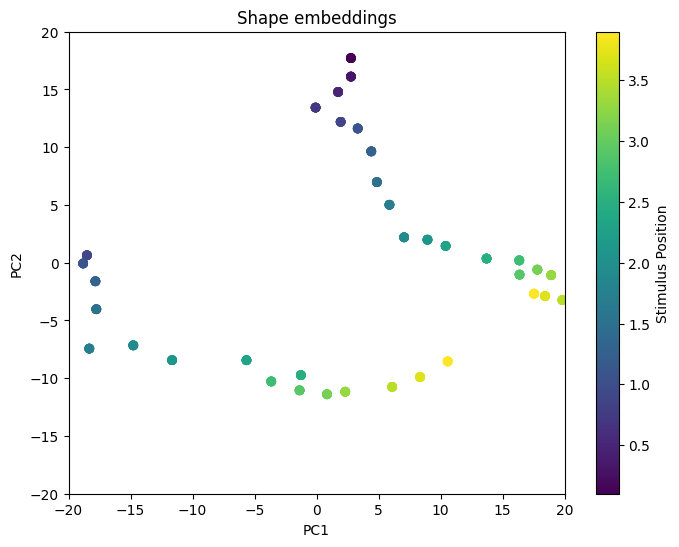

In [4]:
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings_df.drop(columns=['shapes', 'stim_file_pos', 'noise_pos']))
reduced_embeddings_df = pd.DataFrame(reduced_embeddings, columns=['PC1', 'PC2'])

reduced_embeddings_df['stim_file_pos'] = embeddings_df['stim_file_pos'].values
reduced_embeddings_df['noise_pos'] = embeddings_df['noise_pos'].values
reduced_embeddings_df.head()

plt.figure(figsize=(8, 6))
scatter = plt.scatter(reduced_embeddings_df['PC1'], reduced_embeddings_df['PC2'], c=reduced_embeddings_df['stim_file_pos'])
# scatter = plt.scatter(reduced_embeddings_df['PC1'], reduced_embeddings_df['PC2'], c=reduced_embeddings_df['noise_pos'])
plt.colorbar(scatter, label='Stimulus Position')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.xlim(-20,20)
plt.ylim(-20,20)
plt.title('Shape embeddings')
plt.show()


## building architecture

In [5]:
import torch, torch.nn as nn, torch.nn.functional as F, torch.optim as optim

class ShapeSideNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ShapeSideNN, self).__init__()
        
        # single intermediate layer
        self.hidden = nn.Linear(input_dim, hidden_dim)
        
        # separate outputs
        self.reconstruction_output = nn.Linear(hidden_dim, output_dim)
        self.classification_output = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.hidden(x))
        
        # output for reconstruction (continuous)
        reconstruction = self.reconstruction_output(x)
        
        # output for classification (binary)
        classification = torch.sigmoid(self.classification_output(x))
        
        return reconstruction, classification

## format input data

In [ ]:
feature_cols = [col for col in embeddings_df.columns if col.startswith('feature_')]

X_train = embeddings_df[feature_cols].values
y_recon_train = X_train.copy()
y_class_train = (embeddings_df['stim_file_pos'] >= 2).astype(int).values # binary classification (0 or 1)

# Ensure data is a tensor
X_train = torch.tensor(X_train, dtype=torch.float32)
y_recon_train = torch.tensor(y_recon_train, dtype=torch.float32)
y_class_train = torch.tensor(y_class_train, dtype=torch.float32).unsqueeze(1)  # Ensure y_class_train is of shape (N, 1) for binary classification

print(X_train.shape, y_recon_train.shape, y_class_train.shape)

torch.Size([240, 405]) torch.Size([240, 405]) torch.Size([240])


## train

In [9]:
# store losses
train_loss, train_recon_loss, train_class_loss = [], [], []

# define params
input_dim, hidden_dim, output_dim = 405, 128, 405
model = ShapeSideNN(input_dim, hidden_dim, output_dim)

recon_loss_fn, class_loss_fn = nn.MSELoss(), nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# training loop
epochs = 100
for epoch in range(epochs):
    
    # forward pass
    recon_pred, class_pred = model(X_train)
    
    # calculate losses
    loss_recon = recon_loss_fn(recon_pred, y_recon_train)
    loss_class = class_loss_fn(class_pred, y_class_train)
    total_loss = loss_recon + loss_class
    
    # store losses
    train_loss.append(total_loss.item())
    train_recon_loss.append(loss_recon.item())
    train_class_loss.append(loss_class.item())
    
    # backward pass and optimization
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    # if epoch % 10 == 0:
    #     print(f'Epoch {epoch}/{epochs}, Reconstruction Loss: {loss_recon.item()}, Classification Loss: {loss_class.item()}')

# plot losses
plt.figure(figsize=(8, 5))
plt.plot(train_loss, label='Total Loss')
plt.plot(train_recon_loss, label='Reconstruction Loss')
plt.plot(train_class_loss, label='Classification Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curves')
plt.legend()
plt.show()


ValueError: Using a target size (torch.Size([240])) that is different to the input size (torch.Size([240, 1])) is deprecated. Please ensure they have the same size.